<a href="https://colab.research.google.com/github/Manvi1718/Emotion_Analysis/blob/main/MAINdone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMOTION ANALYSIS

## Connecting dataset with kaggle


In [1]:
import os
os.environ["KAGGLE_USERNAME"] = "annmittal"
os.environ["KAGGLE_KEY"] ="b36a820c483a21bd0633e9b284bbc42c"

!kaggle datasets download -d shawon10/ckplus

ckplus.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
#!unzip ckplus.zip

## Loading libraries

In [3]:
pip install split-folders

In [4]:
pip install efficientnet_pytorch

In [5]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#import albumentations
#from albumentations import pytorch as AT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import splitfolders
from torchvision.datasets import ImageFolder
import zipfile
from efficientnet_pytorch import EfficientNet
from tqdm.auto import tqdm

## Setup device agnostic code

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
'''#Splitting dataset into train ,test and validation

original="/content/drive/MyDrive/pytorch/ck+/CK+48"
splitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"

splitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)
'''

'#Splitting dataset into train ,test and validation\n\noriginal="/content/drive/MyDrive/pytorch/ck+/CK+48"\nsplitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"\n\nsplitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)\n'

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd '/content/drive/MyDrive/train_test'

/content/drive/MyDrive/train_test


In [10]:
# To unzip files
"""
#Extract Zip File
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
"""

"\n#Extract Zip File\nwith zipfile.ZipFile('train.zip', 'r') as zip_ref:\n    zip_ref.extractall('train')\n\nwith zipfile.ZipFile('test.zip', 'r') as zip_ref:\n    zip_ref.extractall('test')\n"

In [11]:
# Define transformations, including converting to grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 1 channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust mean and std for 1-channel grayscale
])

In [12]:
# Path to the root directory of your train and test data in Google Drive
train_data_path = '/content/drive/MyDrive/train_test/train/train_d'
test_data_path = '/content/drive/MyDrive/train_test/test/test_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]

In [13]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label

In [14]:
# Load custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

In [15]:
# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
"""# Access labels in the train DataLoader
for images, labels in train_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Train Emotion Label: {emotion_label}")

# Access labels in the test DataLoader
for images, labels in test_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Test Emotion Label: {emotion_label}")
"""

'# Access labels in the train DataLoader\nfor images, labels in train_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Train Emotion Label: {emotion_label}")\n\n# Access labels in the test DataLoader\nfor images, labels in test_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Test Emotion Label: {emotion_label}")\n'

In [17]:
len(train_dataloader) , len(test_dataloader)

(23, 8)

In [18]:
len(train_dataset) , len(test_dataset)

(725, 248)

In [19]:
# see the first training example
image , label = train_dataset[0]
image , label

(tensor([[[-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          [-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          [-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938],
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938],
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938]],
 
         [[-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          [-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          [-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          ...,
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938],
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938],
          [-0.8335, -0.8335, -0.8335,  ..., -0.5938, -0.5938, -0.5938]],
 
         [[-0.6109, -0.6109, -0.6281,  ..., -0.2513, -0.2513, -0.2513],
          [-0.6109, -0.6109,

In [20]:
class_names=emotion_labels
class_names

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [21]:
# Chcek the shape
print(f"image shape : {image.shape}")
print(f"image label : {class_names[label]}")

image shape : torch.Size([3, 224, 224])
image label : surprise


In [22]:
print(emotion_labels[3])

fear


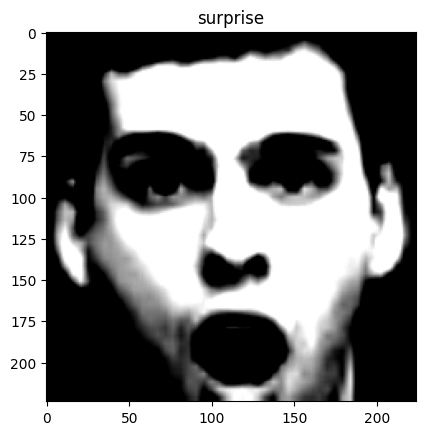

In [23]:
# Assuming your image is in the shape (3, 224, 224)
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(emotion_labels[label])
plt.show()


In [24]:
from torchvision.transforms import Grayscale

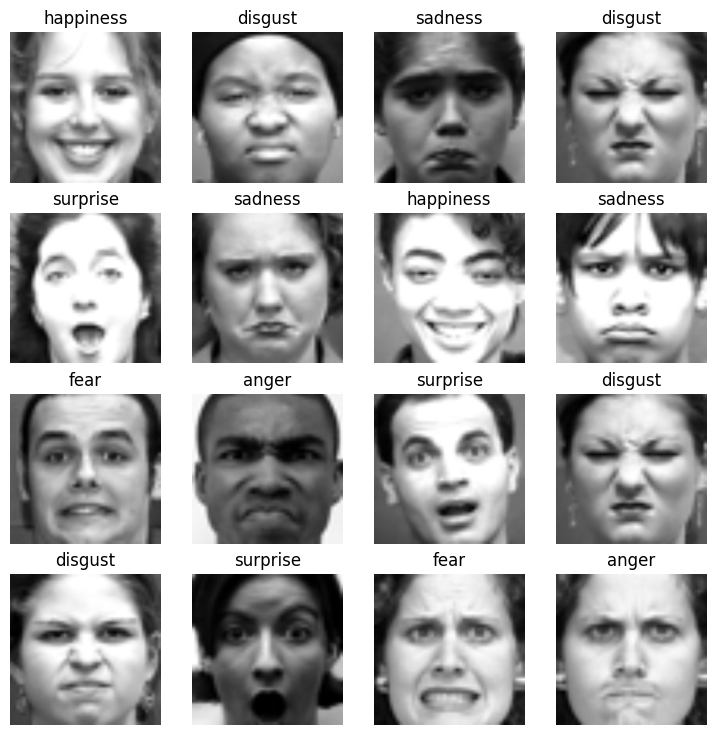

In [25]:
# plot more images
torch.manual_seed(42)
fig =plt.figure(figsize = (9,9))
rows , cols = 4,4

transform = Grayscale(num_output_channels=1)

for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_dataset) , size =[1]).item()
  img , label = train_dataset[random_idx]

  img= transform(img)

  fig.add_subplot(rows,cols , i)
  plt.imshow(img.squeeze() ,cmap="gray")
  plt.title(emotion_labels[label])
  plt.axis(False)

In [26]:
train_dataset , test_dataset

(<__main__.CustomDataset at 0x798275e5fc40>,
 <__main__.CustomDataset at 0x79834c119900>)

In [27]:

# Lets check out what we have created
print(f"dataloaders : {train_dataloader , test_dataloader}")
print(f" length of train_dataloader : {len(train_dataloader)} batches of {batch_size}....")
print(f" length of test_dataloader : {len(test_dataloader)} batches of {batch_size}...")

dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x79834c0cb7f0>, <torch.utils.data.dataloader.DataLoader object at 0x79834c0cb580>)
 length of train_dataloader : 23 batches of 32....
 length of test_dataloader : 8 batches of 32...


In [28]:
# Check out whats inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#Importing models

In [29]:
import torchvision.models as models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

# Some Important functions


In [30]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions already exist")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(request.content)

helper_functions already exist


## Creating a function to timeout our experiments

In [31]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end:float,
                     device:torch.device = None):
  """print difference between start and end time """
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

## Model Evaluation

In [32]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device=device):
  """ Returns a dictionary containing the results of model predicting data loader"""
  loss , acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):

      # Make data device agnostic
      X , y = X.to(device) , y.to(device)
      # Make predictions
      y_pred = model(X)

      #Accumulate the loss and accuracy per batch
      loss += loss_fn(y_pred,y)
      acc+= accuracy_fn(y_true = y,
                        y_pred = y_pred.argmax(dim=1))
    # Scale the loss and acc to find the average loss/ acc per batch
    loss/= len(data_loader)
    acc/= len(data_loader)

  return {"model_name" : model.__class__.__name__, # only works when model was created with a class
          "model_loss" : loss.item(),
          "model_acc" :acc}


## Training Loop

In [33]:
def train_step(model:torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """ performs a training with model trying to learn on data_loader."""
  train_loss,train_acc = 0,0
  # Put model into training mode
  model.train()

  # Add a loop through the training batches
  for batch ,(X,y) in enumerate(data_loader):
    # put data on target device
    X,y= X.to(device) , y.to(device)

    #1. forward pass(outputs ths raw logits)
    y_pred = model(X)

    #2. calculate the loss (per batch)
    loss = loss_fn(y_pred,y)
    train_loss +=loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim=1)) # go from raw logits -> prediction labels

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5. optimzier step
    optimizer.step()

  # Device total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss : {train_loss:.5f} |Train Acc : {train_acc:.2f}% ")


## Testing Loop

In [34]:
def test_step(model:torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
  """ performs a testing loop step on model going over data_loader"""
  test_loss , test_acc=0,0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X,y in data_loader:
      # send the data to the target device
      X,y= X.to(device) , y.to(device)

      #1. forward pass
      test_pred = model(X)

      #2. Calculate the loss / acc
      test_loss += loss_fn(test_pred,y)
      test_acc+= accuracy_fn(y_true = y,y_pred = test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}% ")

#MODEL-1 -- EfficientNet

## Loading EfficientNet model

In [61]:
#1 EfficientNet -- Loading Model
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')
print(efficientnet_model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

## Getting Loss function and optimizer and accuracy metrics

In [62]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = efficientnet_model.parameters(),
                            lr = 0.001)

## Training on Model



In [63]:
# Modify the model's final layers
num_classes = len(class_names)
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, num_classes)  # Modify the last fully connected layer

# measure time
from timeit import default_timer as timer
train_time_start1 = timer()

# setting model to device
efficientnet_model.to(device)

# Set epochs
epochs = 12

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_step(model = efficientnet_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model=efficientnet_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
train_time_end1 = timer()
total_train_time_model_1 = print_train_time(start = train_time_start1,
                                              end = train_time_end1,
                                              device = device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 0.92277 |Train Acc : 73.09% 
Test loss : 0.58330 | Test Acc : 79.95% 
Epoch : 1
----------
Train loss : 0.17137 |Train Acc : 95.72% 
Test loss : 1.29750 | Test Acc : 71.88% 
Epoch : 2
----------
Train loss : 0.12208 |Train Acc : 96.26% 
Test loss : 0.51487 | Test Acc : 81.51% 
Epoch : 3
----------
Train loss : 0.08286 |Train Acc : 97.69% 
Test loss : 0.40699 | Test Acc : 86.07% 
Epoch : 4
----------
Train loss : 0.04623 |Train Acc : 99.18% 
Test loss : 0.24801 | Test Acc : 92.19% 
Epoch : 5
----------
Train loss : 0.02302 |Train Acc : 99.73% 
Test loss : 0.17700 | Test Acc : 96.35% 
Epoch : 6
----------
Train loss : 0.02265 |Train Acc : 99.32% 
Test loss : 0.37748 | Test Acc : 88.15% 
Epoch : 7
----------
Train loss : 0.06979 |Train Acc : 98.37% 
Test loss : 0.11256 | Test Acc : 97.79% 
Epoch : 8
----------
Train loss : 0.05519 |Train Acc : 98.64% 
Test loss : 0.37804 | Test Acc : 90.49% 
Epoch : 9
----------
Train loss : 0.05426 |Train Acc : 98.51% 
T

In [64]:
# Get model_1_results
model_1_results = eval_model(model=efficientnet_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/8 [00:00<?, ?it/s]

{'model_name': 'EfficientNet',
 'model_loss': 0.23157408833503723,
 'model_acc': 93.359375}

## Saving Model

In [65]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Emotion_Analysis_Model")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "efficientnet_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = efficientnet_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Emotion_Analysis_Model/efficientnet_model.pth


#MODEL-2 -- VGG16


## Loading VGG16 model

In [84]:
# VGG16 -- Loading Model
vgg16_model = models.vgg16(pretrained=True)
print(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Getting Loss function and optimizer and accuracy metrics

In [85]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vgg16_model.parameters(),
                            lr = 0.001)

## Training on Model

In [86]:
# Modify the model's final layers
num_classes = len(class_names)
vgg16_model.classifier[6] = nn.Linear(4096, num_classes)  # Modify the last fully connected layer

# measure time
from timeit import default_timer as timer
train_time_start2 = timer()

# setting model to device
vgg16_model.to(device)

epochs = 12

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n---------- ")
  train_step(model = vgg16_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model=vgg16_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
train_time_end2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start2,
                                              end = train_time_end2,
                                              device = device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 0
---------- 
Train loss : 2.08607 |Train Acc : 22.22% 
Test loss : 1.86385 | Test Acc : 20.31% 
Epoch : 1
---------- 
Train loss : 1.85688 |Train Acc : 24.82% 
Test loss : 1.79978 | Test Acc : 27.73% 
Epoch : 2
---------- 
Train loss : 1.63443 |Train Acc : 36.57% 
Test loss : 1.28522 | Test Acc : 54.30% 
Epoch : 3
---------- 
Train loss : 1.36376 |Train Acc : 52.21% 
Test loss : 0.89542 | Test Acc : 68.75% 
Epoch : 4
---------- 
Train loss : 0.89683 |Train Acc : 64.51% 
Test loss : 0.84603 | Test Acc : 70.44% 
Epoch : 5
---------- 
Train loss : 0.64294 |Train Acc : 76.47% 
Test loss : 0.56570 | Test Acc : 73.96% 
Epoch : 6
---------- 
Train loss : 0.52523 |Train Acc : 81.03% 
Test loss : 0.70143 | Test Acc : 72.92% 
Epoch : 7
---------- 
Train loss : 0.52646 |Train Acc : 79.82% 
Test loss : 0.56241 | Test Acc : 82.42% 
Epoch : 8
---------- 
Train loss : 0.34864 |Train Acc : 86.88% 
Test loss : 0.79506 | Test Acc : 77.73% 
Epoch : 9
---------- 
Train loss : 0.33050 |Train Acc :

In [87]:
# Get model_2_results
model_2_results = eval_model(model=vgg16_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_2_results

  0%|          | 0/8 [00:00<?, ?it/s]

{'model_name': 'VGG',
 'model_loss': 0.35587260127067566,
 'model_acc': 86.58854166666667}

## Saving model

In [88]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Emotion_Analysis_Model")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "VGG16.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = vgg16_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Emotion_Analysis_Model/VGG16.pth


#MODEL-3 -- ResNet50

## Loading ResNet50 model

In [71]:
# Resnet50 -- Loading Model
resnet50_model = models.resnet50(pretrained=True)
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Getting Loss function and optimizer and accuracy metrics

In [72]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = resnet50_model.parameters(),
                            lr = 0.001)

## Training on Model

In [73]:
# Modify the model's final layers
num_classes = len(class_names)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)  # Modify the last fully connected layer

# measure time
from timeit import default_timer as timer
train_time_start3 = timer()

# Training loop
resnet50_model.to(device)

# Setting epochs
epochs = 12

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_step(model = resnet50_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model=resnet50_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
train_time_end3 = timer()
total_train_time_model_3 = print_train_time(start = train_time_start3,
                                              end = train_time_end3,
                                              device = device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 0.78895 |Train Acc : 71.25% 
Test loss : 1.48551 | Test Acc : 68.36% 
Epoch : 1
----------
Train loss : 0.23972 |Train Acc : 92.66% 
Test loss : 2.86831 | Test Acc : 50.00% 
Epoch : 2
----------
Train loss : 0.14273 |Train Acc : 95.17% 
Test loss : 0.84513 | Test Acc : 82.94% 
Epoch : 3
----------
Train loss : 0.11936 |Train Acc : 96.87% 
Test loss : 0.96409 | Test Acc : 73.57% 
Epoch : 4
----------
Train loss : 0.11610 |Train Acc : 96.53% 
Test loss : 0.26193 | Test Acc : 90.36% 
Epoch : 5
----------
Train loss : 0.08819 |Train Acc : 97.83% 
Test loss : 0.23211 | Test Acc : 91.28% 
Epoch : 6
----------
Train loss : 0.04203 |Train Acc : 98.91% 
Test loss : 0.22941 | Test Acc : 91.15% 
Epoch : 7
----------
Train loss : 0.02529 |Train Acc : 99.59% 
Test loss : 0.10607 | Test Acc : 97.01% 
Epoch : 8
----------
Train loss : 0.01801 |Train Acc : 99.18% 
Test loss : 0.07214 | Test Acc : 96.88% 
Epoch : 9
----------
Train loss : 0.01101 |Train Acc : 100.00% 


In [74]:
# Get model_3_results
model_3_results = eval_model(model=resnet50_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_3_results

  0%|          | 0/8 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.020209988579154015,
 'model_acc': 99.47916666666667}

## Saving Model

In [75]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Emotion_Analysis_Model")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "ResNet50.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = resnet50_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Emotion_Analysis_Model/ResNet50.pth


#MODEL-4 -- DenseNet121

## Loading DenseNet121 model

In [76]:
# DenseNet121 -- Loading Model
densenet121_model = models.densenet121(pretrained=True)
print(densenet121_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Getting Loss function and optimizer and accuracy metrics

In [77]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = resnet50_model.parameters(),
                            lr = 0.001)

## Training on Model

In [78]:
# Modify the model's final layers
num_classes = len(class_names)
densenet121_model.classifier = nn.Linear(densenet121_model.classifier.in_features, num_classes)  # Modify the last fully connected layer

# measure time
from timeit import default_timer as timer
train_time_start4 = timer()

# setting model to device
densenet121_model.to(device)

epochs = 12

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_step(model = densenet121_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model=densenet121_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
train_time_end4 = timer()
total_train_time_model_4 = print_train_time(start = train_time_start4,
                                              end = train_time_end4,
                                              device = device)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 2.21021 |Train Acc : 13.19% 
Test loss : 2.12218 | Test Acc : 16.15% 
Epoch : 1
----------
Train loss : 2.21740 |Train Acc : 13.46% 
Test loss : 2.21138 | Test Acc : 9.24% 
Epoch : 2
----------
Train loss : 2.21306 |Train Acc : 12.71% 
Test loss : 2.21578 | Test Acc : 11.46% 
Epoch : 3
----------
Train loss : 2.21242 |Train Acc : 13.54% 
Test loss : 2.22579 | Test Acc : 10.29% 
Epoch : 4
----------
Train loss : 2.21766 |Train Acc : 13.53% 
Test loss : 2.22756 | Test Acc : 10.68% 
Epoch : 5
----------
Train loss : 2.21698 |Train Acc : 12.10% 
Test loss : 2.22074 | Test Acc : 10.29% 
Epoch : 6
----------
Train loss : 2.21776 |Train Acc : 14.01% 
Test loss : 2.21945 | Test Acc : 11.20% 
Epoch : 7
----------
Train loss : 2.22177 |Train Acc : 12.51% 
Test loss : 2.21937 | Test Acc : 11.07% 
Epoch : 8
----------
Train loss : 2.21672 |Train Acc : 13.79% 
Test loss : 2.22132 | Test Acc : 10.68% 
Epoch : 9
----------
Train loss : 2.20761 |Train Acc : 14.15% 
Te

In [79]:
# Get model_4_results
model_4_results = eval_model(model=densenet121_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_4_results

  0%|          | 0/8 [00:00<?, ?it/s]

{'model_name': 'DenseNet',
 'model_loss': 2.215878963470459,
 'model_acc': 10.9375}

In [80]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Emotion_Analysis_Model")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "DenseNet121.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = densenet121_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Emotion_Analysis_Model/DenseNet121.pth


# Comparsion between all 4 models

In [89]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results,
                               model_2_results,
                               model_3_results,
                                model_4_results])
compare_results

,model_name,model_loss,model_acc
0,EfficientNet,0.231574,93.359375
1,VGG,0.355873,86.588542
2,ResNet,0.020210,99.479167
3,DenseNet,2.215879,10.937500


In [90]:
# Adding training time to results comparison
compare_results["training_time"] = ([total_train_time_model_1,
                                    total_train_time_model_2,
                                    total_train_time_model_3,
                                    total_train_time_model_4])
compare_results

,model_name,model_loss,model_acc,training_time
0,EfficientNet,0.231574,93.359375,74.481969
1,VGG,0.355873,86.588542,148.767240
2,ResNet,0.020210,99.479167,103.430898
3,DenseNet,2.215879,10.937500,106.704559


Text(0.5, 1.0, 'Model Accuracy')

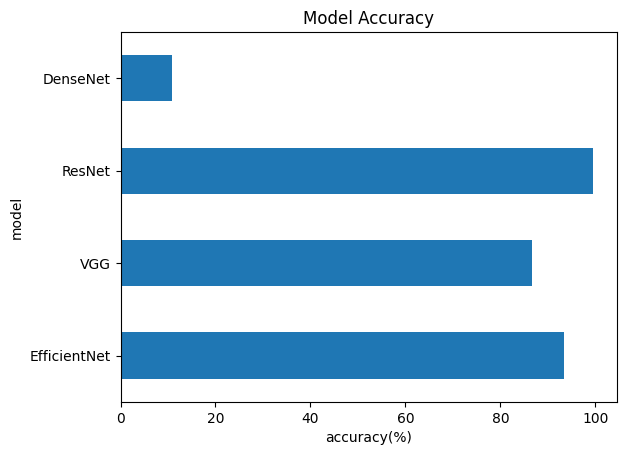

In [91]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")
plt.title("Model Accuracy")

# CONFUSION MATRIX

## Importing `torchmetrics` and `mlxtend`

In [92]:
# see if required packages are installed and ifnot , install them ..
try:
  import torchmetrics , mlxtend
  print(f",mlxtend version : {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]>=19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  print(f"mlxtend version : {mlxtend.__version__}")

,mlxtend version : 0.22.0
mlxtend version : 0.22.0


In [93]:
import mlxtend
print(mlxtend.__version__)

0.22.0


### Labels

In [126]:
import torch

# Initialize an empty list to store the target labels
test_labels = []

# Loop through the test DataLoader to get labels
for images, labels in test_dataloader:
    test_labels.extend(labels.tolist())  # Assuming labels are in tensor format

# Convert the list of labels into a PyTorch tensor
test_labels_tensor = torch.tensor(test_labels)

# Now, test_labels_tensor contains the target labels for the test dataset as a tensor
print(test_labels_tensor)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 4, 4, 6, 4, 4, 4, 4, 6, 4, 4, 4,
        4, 4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2,
        2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 3, 5, 5, 1, 5,
        5, 5, 5, 1, 1, 1, 1, 3, 5, 1, 5, 3, 5, 5, 1, 5, 5, 1, 5, 5, 5, 1, 5, 5,
        1, 5, 3, 5, 3, 3, 5, 5])


## MODEL 1 - EfficientNet

In [144]:
from tqdm.auto import tqdm

#1 . make predictions
y_preds = []
efficientnet_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = efficientnet_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor1 = torch.cat(y_preds)
y_pred_tensor1

making predictions .....:   0%|          | 0/8 [00:00<?, ?it/s]

tensor([6, 6, 5, 1, 3, 3, 1, 3, 5, 0, 6, 4, 1, 6, 1, 2, 1, 4, 1, 3, 0, 4, 3, 0,
        6, 4, 6, 6, 2, 4, 5, 5, 3, 3, 3, 6, 0, 5, 6, 6, 2, 3, 6, 0, 0, 6, 5, 6,
        0, 6, 5, 3, 3, 5, 4, 0, 5, 3, 5, 4, 2, 1, 2, 5, 4, 4, 2, 4, 2, 4, 2, 5,
        2, 0, 2, 4, 3, 1, 5, 0, 6, 0, 4, 1, 5, 5, 5, 5, 2, 4, 0, 1, 4, 4, 5, 5,
        5, 1, 4, 4, 5, 1, 6, 5, 4, 1, 4, 4, 5, 3, 5, 1, 5, 4, 4, 1, 2, 3, 2, 2,
        2, 1, 0, 0, 2, 6, 3, 0, 2, 3, 3, 1, 0, 4, 3, 2, 2, 2, 0, 6, 2, 2, 0, 2,
        5, 3, 0, 0, 6, 1, 1, 5, 3, 1, 1, 3, 6, 6, 2, 4, 6, 0, 5, 2, 6, 5, 1, 0,
        2, 6, 6, 5, 0, 0, 2, 1, 6, 5, 2, 6, 5, 1, 5, 1, 2, 5, 2, 2, 1, 3, 0, 0,
        2, 2, 0, 4, 4, 3, 2, 1, 6, 3, 6, 1, 3, 6, 6, 1, 2, 4, 0, 6, 5, 5, 1, 5,
        2, 5, 5, 1, 1, 1, 1, 4, 5, 1, 2, 4, 4, 5, 1, 2, 6, 1, 5, 0, 2, 6, 0, 5,
        1, 5, 2, 5, 3, 6, 6, 0])

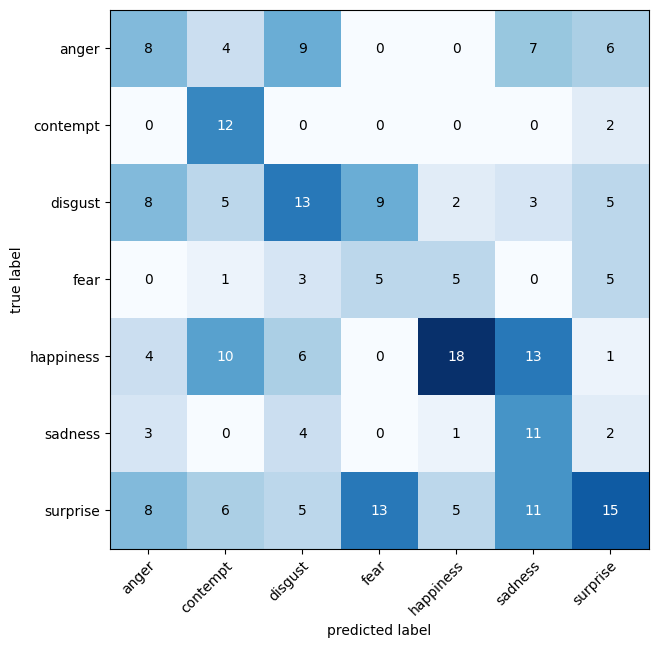

In [145]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(emotion_labels),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor1,
                         target = test_labels_tensor)

# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## MODEL 2 - VGG16

In [146]:
from tqdm.auto import tqdm

#1 . make predictions
y_preds = []
vgg16_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = vgg16_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor2 = torch.cat(y_preds)
y_pred_tensor2

making predictions .....:   0%|          | 0/8 [00:00<?, ?it/s]

tensor([5, 0, 2, 4, 3, 4, 4, 5, 6, 2, 4, 3, 1, 0, 4, 6, 4, 3, 1, 0, 5, 3, 3, 3,
        5, 1, 6, 6, 6, 3, 4, 4, 3, 3, 3, 6, 5, 2, 5, 3, 5, 0, 2, 3, 0, 0, 3, 5,
        0, 0, 5, 5, 5, 5, 1, 6, 2, 3, 3, 2, 0, 1, 4, 5, 1, 1, 1, 3, 3, 2, 1, 1,
        0, 4, 1, 1, 5, 1, 3, 1, 6, 4, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
        1, 1, 1, 6, 6, 1, 6, 1, 1, 4, 3, 4, 6, 5, 6, 4, 1, 4, 1, 1, 0, 6, 5, 0,
        6, 1, 5, 5, 0, 6, 2, 5, 6, 1, 3, 6, 5, 4, 5, 6, 6, 6, 2, 6, 6, 1, 5, 5,
        6, 5, 3, 0, 1, 0, 1, 1, 1, 6, 6, 6, 6, 0, 0, 4, 2, 6, 1, 0, 5, 4, 1, 0,
        0, 1, 5, 2, 1, 1, 0, 1, 4, 1, 0, 2, 3, 4, 5, 1, 5, 5, 1, 4, 3, 5, 1, 4,
        2, 0, 5, 6, 4, 5, 6, 1, 3, 6, 6, 1, 6, 6, 1, 1, 6, 6, 2, 3, 1, 5, 4, 5,
        6, 5, 5, 4, 1, 4, 1, 6, 3, 1, 5, 3, 5, 3, 1, 0, 5, 4, 6, 0, 2, 6, 2, 6,
        2, 3, 0, 3, 6, 3, 6, 2])

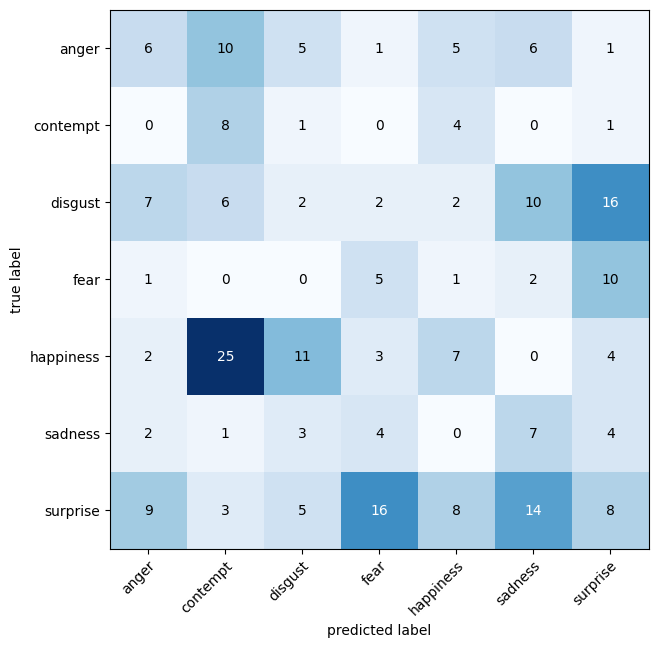

In [147]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(emotion_labels),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor2,
                         target = test_labels_tensor)

# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## MODEL 3 - ResNet50

In [148]:
from tqdm.auto import tqdm

#1 . make predictions
y_preds = []
resnet50_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = resnet50_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor3 = torch.cat(y_preds)
y_pred_tensor3

making predictions .....:   0%|          | 0/8 [00:00<?, ?it/s]

tensor([1, 3, 2, 2, 1, 3, 2, 3, 5, 0, 3, 4, 1, 0, 0, 3, 1, 4, 1, 6, 5, 6, 6, 5,
        4, 5, 1, 4, 2, 2, 4, 6, 2, 0, 3, 1, 5, 5, 5, 6, 5, 2, 2, 1, 1, 3, 6, 2,
        0, 3, 6, 5, 6, 5, 4, 1, 2, 1, 2, 4, 1, 0, 4, 6, 4, 5, 3, 5, 3, 0, 1, 1,
        0, 4, 2, 2, 6, 1, 4, 3, 6, 0, 2, 4, 0, 4, 5, 1, 4, 2, 5, 0, 4, 4, 1, 3,
        1, 4, 1, 4, 1, 4, 1, 5, 5, 4, 6, 4, 3, 0, 3, 0, 4, 4, 3, 1, 2, 5, 6, 0,
        5, 4, 0, 0, 2, 2, 2, 2, 2, 5, 6, 2, 0, 4, 5, 3, 0, 2, 0, 0, 2, 2, 3, 5,
        2, 0, 0, 5, 6, 3, 1, 1, 2, 6, 4, 1, 0, 6, 0, 4, 4, 0, 1, 0, 5, 2, 1, 5,
        5, 6, 5, 2, 1, 1, 0, 5, 6, 1, 0, 6, 0, 0, 2, 1, 2, 1, 0, 4, 4, 3, 0, 2,
        2, 2, 0, 4, 4, 6, 3, 6, 3, 6, 4, 4, 3, 6, 6, 4, 3, 4, 0, 3, 5, 5, 1, 5,
        5, 6, 6, 4, 1, 1, 1, 4, 5, 1, 2, 3, 2, 5, 6, 5, 0, 0, 6, 2, 2, 6, 2, 5,
        1, 5, 3, 5, 4, 6, 6, 0])

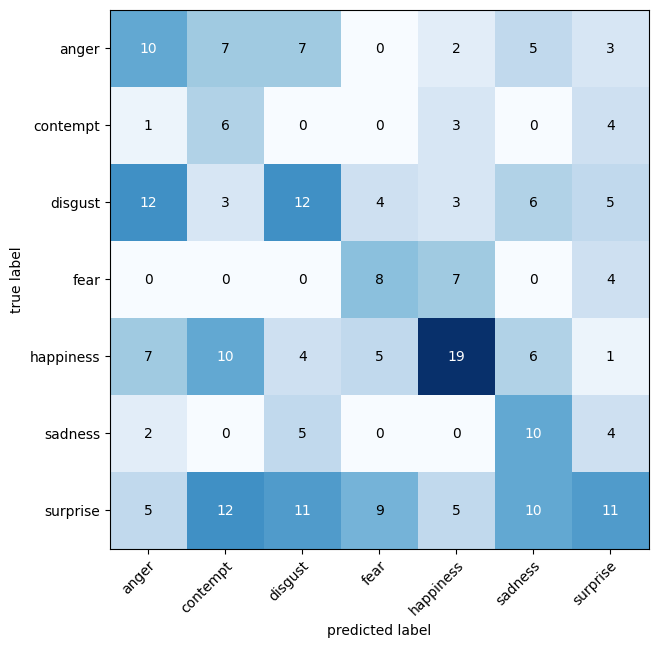

In [149]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(emotion_labels),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor3,
                         target = test_labels_tensor)

# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## MODEL 4 - DenseNet121

In [150]:
from tqdm.auto import tqdm

#1 . make predictions
y_preds = []
densenet121_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = densenet121_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor4 = torch.cat(y_preds)
y_pred_tensor4

making predictions .....:   0%|          | 0/8 [00:00<?, ?it/s]

tensor([3, 3, 6, 0, 1, 0, 4, 5, 2, 2, 0, 2, 0, 5, 2, 4, 4, 3, 5, 5, 1, 6, 2, 6,
        0, 2, 6, 6, 4, 4, 0, 0, 5, 6, 2, 2, 1, 1, 2, 0, 0, 6, 6, 6, 6, 3, 4, 4,
        4, 3, 5, 5, 4, 5, 6, 0, 0, 1, 4, 3, 2, 2, 3, 3, 2, 5, 2, 6, 6, 6, 2, 6,
        3, 0, 0, 1, 5, 5, 1, 1, 4, 1, 5, 4, 6, 3, 2, 1, 6, 1, 0, 0, 2, 2, 2, 4,
        0, 4, 3, 2, 1, 1, 6, 4, 2, 1, 6, 3, 2, 2, 4, 0, 3, 6, 4, 0, 5, 6, 5, 2,
        6, 5, 5, 5, 5, 2, 6, 5, 5, 2, 2, 5, 1, 6, 3, 1, 1, 4, 2, 0, 4, 1, 0, 3,
        3, 4, 2, 2, 4, 6, 3, 1, 2, 4, 6, 3, 6, 3, 0, 6, 1, 4, 5, 4, 2, 1, 2, 6,
        3, 6, 6, 6, 2, 0, 3, 2, 2, 5, 4, 5, 6, 2, 5, 3, 3, 0, 3, 5, 0, 0, 1, 6,
        6, 6, 5, 4, 3, 6, 6, 2, 1, 0, 5, 0, 1, 4, 5, 5, 4, 0, 1, 1, 6, 0, 0, 4,
        4, 6, 6, 3, 2, 2, 1, 1, 0, 2, 0, 5, 3, 0, 0, 1, 6, 3, 1, 3, 3, 6, 5, 2,
        3, 1, 2, 3, 2, 4, 1, 6])

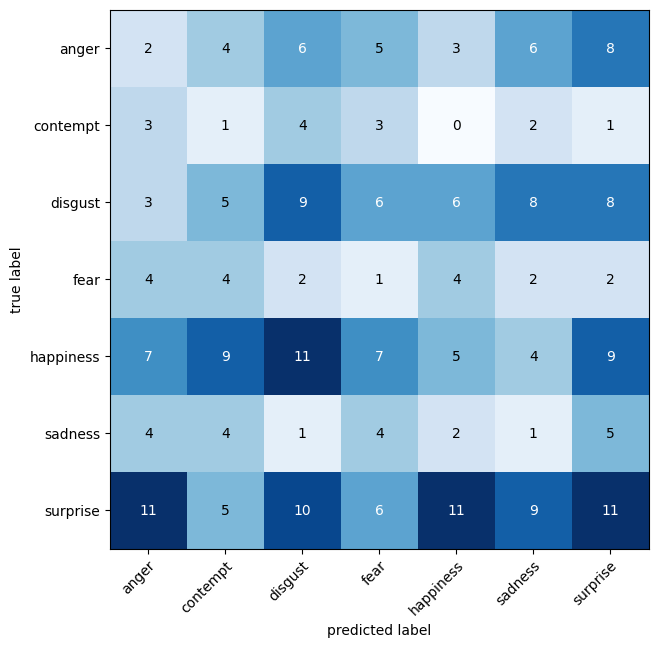

In [151]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(emotion_labels),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor4,
                         target = test_labels_tensor)

# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)